In [12]:
import sys
import idx2numpy
import pandas as pd
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset, Subset, random_split

# 数据预处理
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 加载完整的 MNIST 训练数据集
full_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# 随机选择 20,000 个样本
subset_indices = torch.randperm(len(full_dataset))[:20000]
subset_dataset = Subset(full_dataset, subset_indices)

# 将 20,000 个样本分为 5,000 个训练集、5,000 个验证集和 10,000 个测试集
train_set, val_set, test_set = random_split(subset_dataset, [5000, 5000, 10000])

# 打乱训练集中的 2,500 个样本的标签
rand_indices = torch.randperm(len(train_set))[:2500]
for idx in rand_indices:
    # 随机生成一个新的标签
    new_label = torch.randint(0, 10, (1,)).item()
    train_set.dataset.dataset.targets[subset_indices[train_set.indices[idx]]] = new_label

# 创建数据加载器
trainloader = DataLoader(train_set, batch_size=64, shuffle=True)
valloader = DataLoader(val_set, batch_size=64, shuffle=True)
testloader = DataLoader(test_set, batch_size=64, shuffle=True)


In [14]:
# 定义神经网络
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

net = SimpleNet()

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)


# 测试网络
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %')

# 训练网络
for epoch in range(5):
    running_loss = 0.0
    for i, data in enumerate(valloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 200 == 199:
            print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0

print('Finished Training')

# 测试网络
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %')

Accuracy of the network on the 10000 test images: 7.99 %
Finished Training
Accuracy of the network on the 10000 test images: 88.29 %


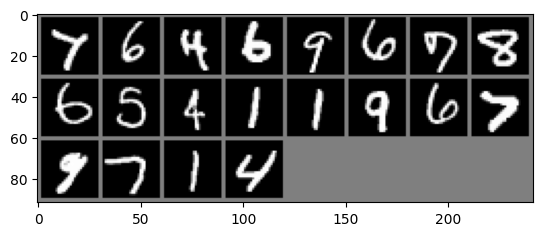

0 6 4 6 1 4 7 3 9 5 4 4 1 9 6 3 9 1 1 4


In [15]:
# 查看图片及标签
import matplotlib.pyplot as plt
import torchvision
import numpy as np


def imshow(img):
    # 反标准化
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 获取一批图像
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 显示 20 张图像
imshow(torchvision.utils.make_grid(images[:20]))

# 打印标签
print(' '.join(f'{labels[j].item()}' for j in range(20)))
